# Obsah

> ## Úvod

> ## Knižnice

> ## Dataset

> ## Chýbajúce hodnoty

>> ### Zjednotenie formátov dát

>> ### Odvodenie chýbajúcich hodnôt po riadkoch

>> ### Doplnenie chýbajúcich hodnôt po stĺpcoch

> ## Vychýlené hodnoty

> ## Normalizácia údajov

> ## Transformácia numerických atribútov na kategorické

> ## Transformacia kategorických údajov na numerické

> ## Vytváranie atribútov kombinovanim

> ## Zdroje

## Doležité parametre
DecisionTreeClassifier(
criterion

max_depth=None

min_samples_leaf - počet pozorovani vo vyslednej podmnozine

class_weight=None

# Úvod
Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte ​csv​) vo vhodnom tvare pre zvolený algoritmus strojového učenia (v našom prípade rozhodovacie stromy​). Zároveň, keďže predspracovaním sa mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), treba znovu zrealizovať podstatné časti prieskumnej analýzy, pričom v tejto fáze je potrebné zamerať sa aj na vzťahy medzi jednotlivými atribútmi.

# Knižnice

In [909]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing
from sklearn import linear_model
import datetime as dt

#regular expression
import re

#Nastavenie rozmerov zobrazovaných grafov
plt.rcParams['figure.figsize'] = 9, 6
from IPython.display import Image

#Integracia
from scipy.stats import boxcox
import scipy.stats as stats

# Func Defintions

In [910]:
def fixWierdCharsInString(string):
    if isinstance(string, float) or isinstance(string, int):
        return string
    if not isinstance(string, str): 
        return string
    if pd.isna(string) or string == '?' or string == '??':
        return np.nan
    #ocisti string od bielych znakov a regex: nahrad znaky [ -], za _
    return re.sub('[ -]','_', str.strip(string).upper())

In [911]:
def init_dataset(file):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep=',', index_col=0)
    # Pomenujeme si index
    data.index.name = 'ID'
    # Ujednoti format nazvov stlpcov
    data = data.rename(columns=fixWierdCharsInString)
    print("Index name", data.index.name)
    print(data.columns)
    return data

In [912]:
def create_csv(df, file_name):
    df.to_csv(file_name, sep='\t')

In [913]:
def isNormalDistribution(data):
    z, pval = stats.normaltest(data)
    print(data.name, z, pval, True if pval > 0.05 else False)
    if(pval > 0.05):
        return True
    return False

Na základe: http://mathforum.org/library/drmath/view/72065.html sme určili prahovú hodnotu kedy považujeme atribút za normálne rozdelenie

In [914]:
def checkAllObjectType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    for col_name in data.select_dtypes('object'):
        #Spočítame si pre každý "kategorický" atribút počet jeho jedinečných hodnôt
        print(col_name,":",data[col_name].nunique())  


In [915]:
def checkAllNumericType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    numeric_data = data.select_dtypes(['int64','float64'])
    for col_name in numeric_data.columns:
        #Spočítame si pre každý "Numerický" atribút počet jeho jedinečných hodnôt
        print(col_name,": modus:",numeric_data[col_name].mode(),", mean:", numeric_data[col_name].describe())
    numeric_data.apply(isNormalDistribution)

In [916]:
def convertToDateType(string):
    if pd.isna(string) or string == '??':
        return pd.NaT
    #Nastavime si datum na 10 znakov
    if isinstance(string, str):
        string = string.strip()[:10]
        if len(string) < 10:
            if(re.match("^[01][0-8]",string[:2])):
                #print(string)
                string = '20'+ string
            elif(re.match("^[2-9][0-9]",string[:2])): 
                string = '19'+ string
                #print(string)
    try: return pd.to_datetime(string, errors='raise')
    except ValueError:
            #print(string)
            return pd.NaT

In [917]:
def fixWierdCharsInObjectType(data):
    forloop = {}
    for col in data.columns:
        data[col] = data[col].apply(fixWierdCharsInString)
        forloop[col] = data[col].value_counts(normalize=True).to_dict()
    return forloop

In [918]:
def calculateAgeFromDate(data, start_date):
    date = pd.to_datetime(start_date)
    data.loc[data[age_column].isna() & data[date_column].notna(), age_column] = (date - data.loc[(data[age_column].isna() & data[date_column].notna()), date_column]).astype('int64') 

# Dataset

In [919]:
#Inicializacia datasetu so zjednotenými nazvami
test_file = "data/zadanie4/test.csv"
test_data = init_dataset(test_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [920]:
train_file = "data/zadanie4/train.csv"
train_data = init_dataset(train_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [921]:
#Aby sme mohli pracovat 
#data = train_data
data = train_data

# Zjednotenie formátov a typov dát

In [922]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 2799
Data columns (total 39 columns):
AGE                          2799 non-null float64
SEX                          2800 non-null object
ON_THYROXINE                 2800 non-null object
QUERY_ON_THYROXINE           2800 non-null object
ON_ANTITHYROID_MEDICATION    2800 non-null object
SICK                         2800 non-null object
PREGNANT                     2800 non-null object
THYROID_SURGERY              2800 non-null object
I131_TREATMENT               2800 non-null object
QUERY_HYPOTHYROID            2800 non-null object
QUERY_HYPERTHYROID           2800 non-null object
LITHIUM                      2800 non-null object
GOITRE                       2800 non-null object
TUMOR                        2800 non-null object
HYPOPITUITARY                2800 non-null object
PSYCH                        2800 non-null object
TSH_MEASURED                 2800 non-null object
TSH                          2516 non-null

In [923]:
checkAllObjectType(data)

SEX : 3
ON_THYROXINE : 6
QUERY_ON_THYROXINE : 2
ON_ANTITHYROID_MEDICATION : 2
SICK : 2
PREGNANT : 2
THYROID_SURGERY : 2
I131_TREATMENT : 2
QUERY_HYPOTHYROID : 2
QUERY_HYPERTHYROID : 2
LITHIUM : 2
GOITRE : 2
TUMOR : 2
HYPOPITUITARY : 2
PSYCH : 2
TSH_MEASURED : 2
T3_MEASURED : 2
TT4_MEASURED : 2
T4U_MEASURED : 2
FTI_MEASURED : 2
FTI : 210
TBG_MEASURED : 1
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 2800
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 2456
PERSONAL_INFO : 700


Pre všetky vyššie atribúty nastavíme správny formát dát a prekonvertujeme na číselnú reprezentáciu, kvôli neskoršej klasifikácií.

In [924]:
#help(data.to_numeric)
#If ‘coerce’, then invalid parsing will be set as NaN
#FTI prekonvertujeme na čísla
column=fixWierdCharsInString('FTI')
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column].describe()

count    2505.000000
mean      110.787984
std        32.883986
min         2.000000
25%        93.000000
50%       107.000000
75%       124.000000
max       395.000000
Name: FTI, dtype: float64

Zmena hodnôt **M -> Male** a **F -> Female**, **? -> NaN**. 

In [925]:
#Nastavíme pohlavie na jeden formát
column = fixWierdCharsInString('sex')

data[column] = data[column].apply(fixWierdCharsInString)
data[column].replace(['F', 'M'], ['female', 'male'], inplace=True)
#data[column] = data[column].fillna(-1)
data[column].value_counts()
#new_column = fixWierdCharsInString('sex_male')
#data = data.rename(columns={column:new_column})
#data.columns[1]

female    1830
male       860
Name: SEX, dtype: int64

Zmena hodnôt **f, F, FALSE -> False** a **t, T, TRUE -> True**

In [926]:
data.replace(['f', 'F', 'FALSE', 't', 'T', 'TRUE'], [False, False, False, True, True, True], inplace=True)

In [927]:
checkAllObjectType(data)

SEX : 2
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 2800
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 2456
PERSONAL_INFO : 700


In [928]:
column = fixWierdCharsInString('relationship')
data[column].value_counts()

 Not-in-family     809
 Husband           550
 Unmarried         510
 Own-child         441
 Wife              253
 Not_in_family      95
 Other-relative     80
 Own_child          53
 Other_relative      9
Name: RELATIONSHIP, dtype: int64

Ujednotenie názvov v stĺpci **relationship**. 
Own-child -> Own_child
Not-in-family -> Not_in_family
Other-relative -> Other_relative

In [929]:
data[column] = data[column].apply(fixWierdCharsInString)
data[column].value_counts()

NOT_IN_FAMILY     904
HUSBAND           550
UNMARRIED         510
OWN_CHILD         494
WIFE              253
OTHER_RELATIVE     89
Name: RELATIONSHIP, dtype: int64

Ujednotenie formátu atribútu **date_of_birth**

In [930]:
column = fixWierdCharsInString('date_of_birth')
data[column] = data[column].apply(convertToDateType)
data[column].describe()

count                    2519
unique                   2394
top       1957-08-19 00:00:00
freq                        3
first     1923-05-30 00:00:00
last      2016-11-03 00:00:00
Name: DATE_OF_BIRTH, dtype: object

Rozdelenie stĺpca **personal_info** do viacerých stĺpcov

In [931]:
column = fixWierdCharsInString('personal_info')
columns = list(map(fixWierdCharsInString, ['job','state', 'marital_status', 'job_segment', 'race']))
df_personal_data = pd.DataFrame(data[column].str.replace('\n','|').str.replace('--','|').str.split('|', expand=False).tolist(), columns=columns)
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,Other-service,United-States,Widowed,private,Black
1,Adm-clerical,United-States,Separated,Local-gov,White
2,Sales,United-States,Married-civ-spouse,private,White
3,Sales,United-States,Never-married,Private,Black
4,Adm-clerical,United-States,Never-married,Private,White


Atribút je teraz rozdelený do viacerých stĺpcov **job, state, parents_definition, segment, race**, ale je potrebné v nich urobiť nejaké úpravy. 

In [932]:
checkAllObjectType(df_personal_data)

JOB : 14
STATE : 37
MARITAL_STATUS : 7
JOB_SEGMENT : 15
RACE : 5


In [933]:
fixWierdCharsInObjectType(df_personal_data)

{'JOB': {'ADM_CLERICAL': 0.1654482493266641,
  'CRAFT_REPAIR': 0.07772220084647942,
  'EXEC_MANAGERIAL': 0.13659099653712967,
  'FARMING_FISHING': 0.021546748749519045,
  'HANDLERS_CLEANERS': 0.02308580223162755,
  'MACHINE_OP_INSPCT': 0.06156213928434013,
  'OTHER_SERVICE': 0.15390534821085033,
  'PRIV_HOUSE_SERV': 0.011158137745286649,
  'PROF_SPECIALTY': 0.14697960754136205,
  'PROTECTIVE_SERV': 0.019622931896883418,
  'SALES': 0.12158522508657175,
  'TECH_SUPPORT': 0.032320123124278566,
  'TRANSPORT_MOVING': 0.02847248941900731},
 'JOB_SEGMENT': {'?': 0.07107142857142858,
  'FEDERAL_GOV': 0.029285714285714286,
  'LOCAL_GOV': 0.07785714285714286,
  'NEVER_WORKED': 0.0007142857142857143,
  'PRIVATE': 0.6982142857142857,
  'SELF_EMP_INC': 0.024642857142857143,
  'SELF_EMP_NOT_INC': 0.055,
  'STATE_GOV': 0.04285714285714286,
  'WITHOUT_PAY': 0.00035714285714285714},
 'MARITAL_STATUS': {'DIVORCED': 0.18535714285714286,
  'MARRIED_AF_SPOUSE': 0.00035714285714285714,
  'MARRIED_CIV_SPOUSE

In [934]:
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK
1,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE
2,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE
3,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK
4,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE


Teraz môžeme vytvorené stĺpce z atribútu **personal_info** pripojiť k celému datasetu a vymazať atribút **personal_info**.

In [935]:
data = data.drop([column], axis=1) # vymazanie atribútu personal_info
data = data.join(df_personal_data)          # pridanie nových atribútov do nášho datasetu

Rozdelenie atribútu **class** do dvoch nových atribútov.

In [936]:
column = fixWierdCharsInString('class')
data[column].head()

ID
0    replacement therapy.|3560
1                negative.|311
2               negative.|3705
3               negative.|2668
4    replacement therapy.|1668
Name: CLASS, dtype: object

In [937]:
#data = train_data
#Nepotrebujeme
column2_name = 'second_id'
df_class = pd.DataFrame(data[column].str.split('\.\|').tolist(), columns = [column,column2_name])
df_class[column].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: CLASS, dtype: int64

In [938]:
# vymazanie atribútu class
data = data.drop([column], axis=1) 
# pridanie nových atribútov do nášho datasetu
data = data.join(df_class[column])
data[column].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: CLASS, dtype: int64

In [939]:
column = fixWierdCharsInString('education_num')
#data['education-num']
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column] = data[column].apply(lambda x: abs(x)/100 if abs(x) > 100 else x)
data[column].value_counts()

9.0     894
10.0    670
13.0    437
14.0    138
11.0    130
12.0    103
7.0      97
6.0      79
8.0      54
4.0      45
15.0     42
5.0      41
16.0     25
3.0      24
2.0      17
1.0       4
Name: EDUCATION_NUM, dtype: int64

Vymazanie atribútu **TBG**, pretože atribút nenesie žiadnu zmysluplnú hodnotu a tým pádom nemá pre nás význam. 

In [940]:
column1 = fixWierdCharsInString('TBG')
column2 = fixWierdCharsInString('TBG_measured')
data = data.drop([column1], axis=1) 
data = data.drop([column2], axis=1) 

Atribútom **capital_gain** a **capital_loss** sme sa rozhodli ujednotiť dátové typy.

In [941]:
column = fixWierdCharsInString('capital_loss')
data[column] = data[column].astype('float64')

In [942]:
fixWierdCharsInObjectType(data)
checkAllObjectType(data)
data.select_dtypes('object').head()

SEX : 2
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 36
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


,SEX,REFERRAL_SOURCE,EDUCATION,RELATIONSHIP,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,,
0,FEMALE,OTHER,SOME_COLLEGE,UNMARRIED,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK,REPLACEMENT_THERAPY
1,FEMALE,OTHER,SOME_COLLEGE,UNMARRIED,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE,NEGATIVE
2,MALE,OTHER,HS_GRAD,HUSBAND,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,NEGATIVE
3,FEMALE,OTHER,SOME_COLLEGE,OWN_CHILD,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK,NEGATIVE
4,FEMALE,OTHER,ASSOC_VOC,OWN_CHILD,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,REPLACEMENT_THERAPY


Po zjednotení formátov dát nám ostali len tieto atribúty s dátovým typom object. Kedže sa jedná o kategorické atribúty tak sme zatial spokojný s týmto dátovým typom.

# Normalizácia dát

In [943]:
numeric_data = data.select_dtypes(include=['float', 'int'])

In [944]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
#numeric_data.dropna().apply(isNormalDistribution)
pd.DataFrame(s).apply(isNormalDistribution)

0 3.718038752969771 0.1558253614836185 True


0    True
dtype: bool

In [945]:
measures = data.loc[:, ['TSH', 'T4U', 'T3', 'TT4', 'FTI']]
measures.head()

,TSH,T4U,T3,TT4,FTI
ID,,,,,
0,2.90,NaN,1.2,174.0,NaN
1,0.20,0.97,NaN,105.0,108.0
2,2.10,NaN,1.7,96.0,NaN
3,0.02,1.10,3.4,91.0,83.0
4,0.69,0.99,NaN,162.0,163.0


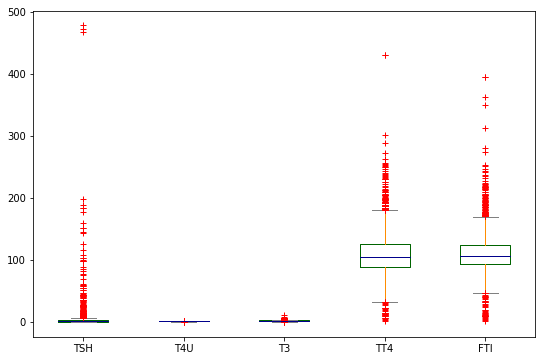

In [946]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
measures.plot.box(color=color, sym='r+', positions=[3, 4, 5, 6, 7])

In [947]:
# sklearn.preprocessing
#measures.fillna(0, inplace=True)
measures.dropna(inplace=True)
tmp = pd.DataFrame(preprocessing.scale(measures))
#tmp = pd.DataFrame()
#for column in measures:
 #   tmp[column] = preprocessing.scale(measures[column], axis=0)

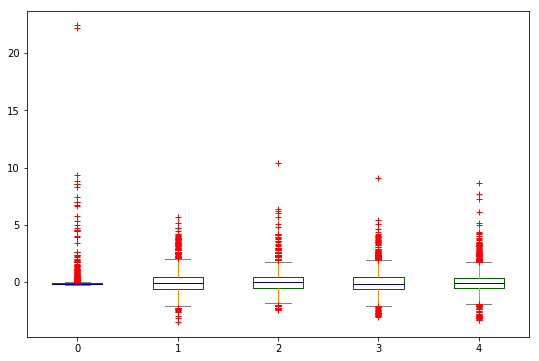

In [948]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
pd.DataFrame(tmp).plot.box(color=color, sym='r+')

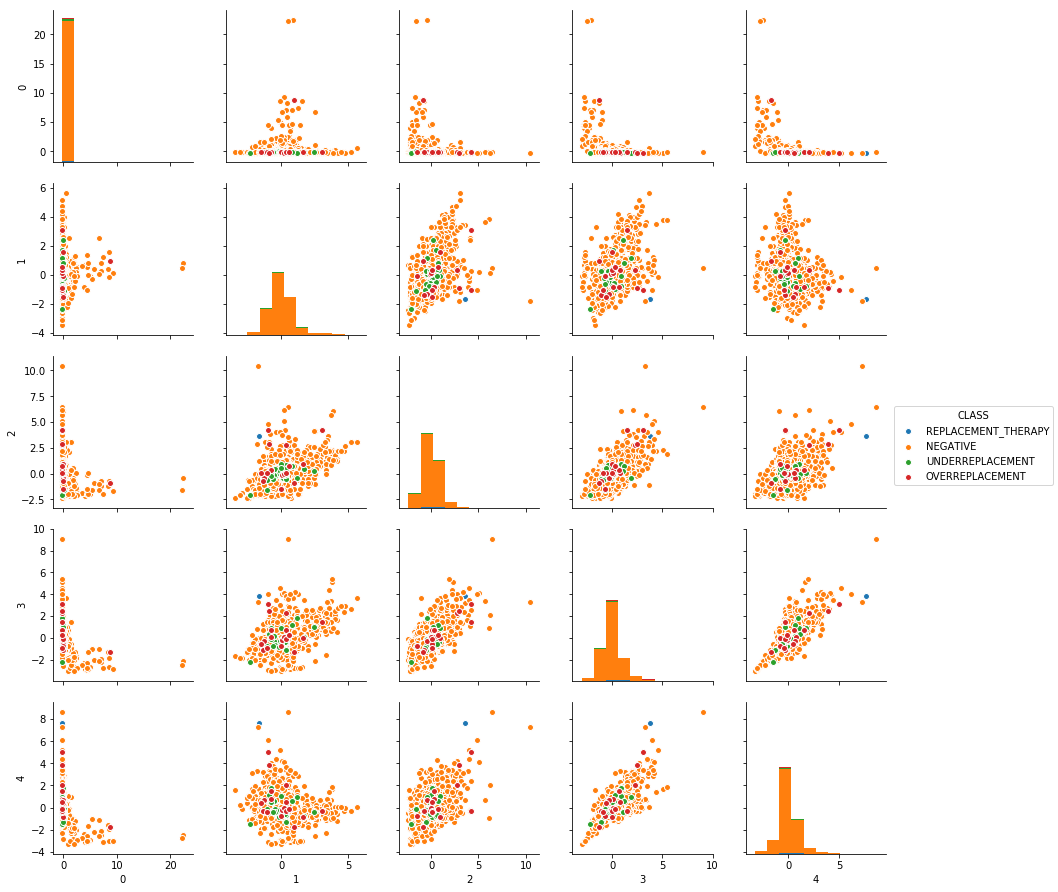

In [949]:
column1_name = 'CLASS'

tmp[column1_name] = data[column1_name]

seaborn.pairplot(tmp, dropna=True, hue=column1_name)

In [950]:
numeric_data.apply(count_missing)

AGE                 1
TSH               284
T3                585
TT4               184
T4U               297
FTI               295
FNLWGT              0
EDUCATION_NUM       0
CAPITAL_GAIN      280
CAPITAL_LOSS        0
HOURS_PER_WEEK      0
dtype: int64

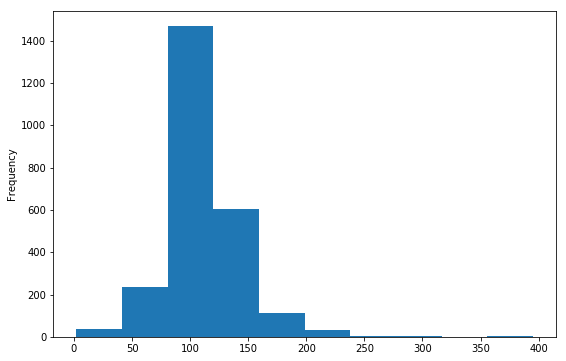

In [951]:
numeric_data['FTI'].plot.hist()

In [952]:
# z-normalization: shift = mean, scale = std
# 0-1 normalization: shift = min, scale =  max - min
# toto iste robi StandardScaler pre vsetky atributy. Pozor ale na power law
# ak pouzijete RobustScaler, tak si viete poradit aj s outliermi (pouziva rozsah 1st quartile (25th quantile) and the 3rd quartile (75th quantile))
def normalization(data, shift, scale): 
    return (np.array(data) - float(shift))/scale

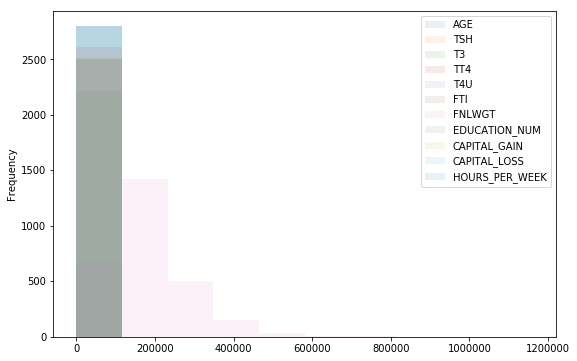

In [953]:
numeric_data.plot.hist(alpha=0.1)

In [954]:
data['TSH'].isna().sum()

284

Text(0.5,1,'index: %d (without box-cox)')

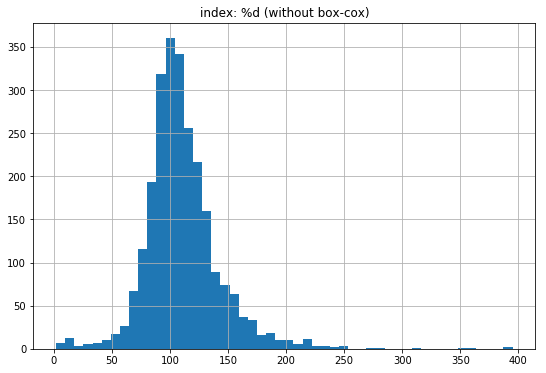

In [955]:

transformed = data['FTI'].dropna()# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title("index: %d (without box-cox)")

Text(0.5,1,'index: 20 (box-cox)')

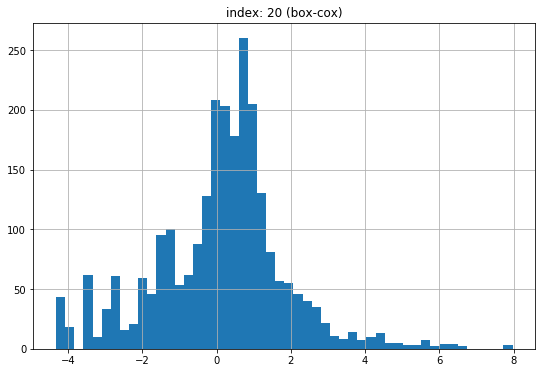

In [956]:
index = 20
transformed, att = boxcox(data['TSH'].dropna())# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title("index: %d (box-cox)" % index)

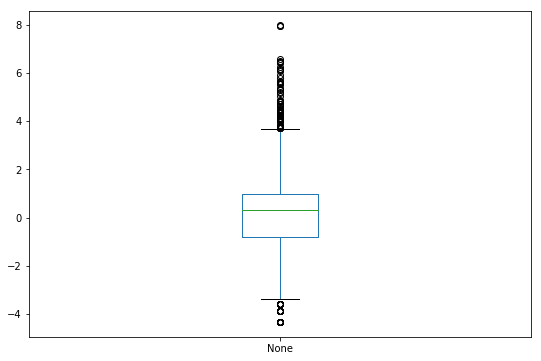

In [957]:
pd.Series(transformed).plot(kind='box')

Text(0.5,1,'throughput (Z-normalization)')

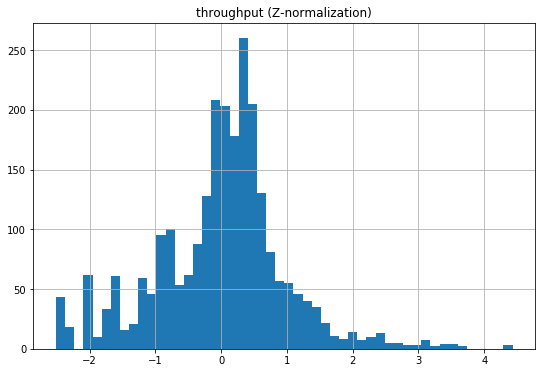

In [958]:
z_transformed = normalization(transformed, np.mean(transformed), np.std(transformed))
pom = pd.Series(z_transformed).hist(bins=50)
pom.set_title('throughput (Z-normalization)')

Text(0.5,1,'throughput (Z-normalization)')

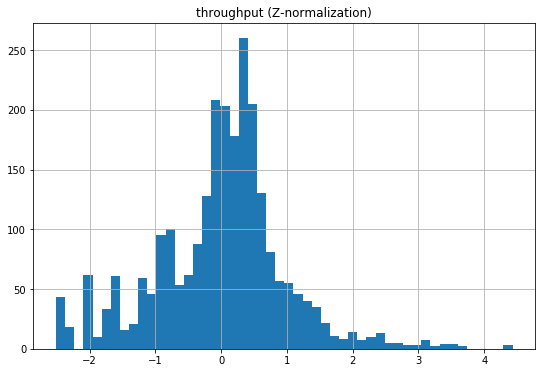

In [959]:
# sklearn.preprocessing
preprocessing.scale(transformed)
pom = pd.Series(z_transformed).hist(bins=50)
pom.set_title('throughput (Z-normalization)')

# Vychýlené hodnoty
V tejto časti sa snažíme spracovať vychýlené hodnoty numerických dát.

Atribút **age** odstránenie odchýlených hodnôt.

In [960]:
column = fixWierdCharsInString('age')
data[(data[column] < 1) | (data[column] > 100)]

,AGE,SEX,ON_THYROXINE,QUERY_ON_THYROXINE,ON_ANTITHYROID_MEDICATION,SICK,PREGNANT,THYROID_SURGERY,I131_TREATMENT,QUERY_HYPOTHYROID,...,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,DATE_OF_BIRTH,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,,,,,,,,,,,,,
685,455.0,FEMALE,False,False,False,False,False,False,False,False,...,0.0,0.0,40,NaT,SALES,UNITED_STATES,DIVORCED,PRIVATE,WHITE,NEGATIVE


# Chýbajúce hodnoty

Počty chýbajúcich hodnôt v jednotlivých atribútoch.
!!!http://scikit-learn.org/stable/data_transforms.html!!!

In [961]:
def count_missing(data):
    null_data = pd.isnull(data)
    null_count = np.sum(null_data)
    return (null_count)

In [962]:
def prop_missing(data):
    num = count_missing(data)
    dem = data.size
    return num/dem

In [963]:
def prop_complete(data):
    return 1 - prop_missing(data)

In [964]:
data.apply(count_missing)

AGE                            1
SEX                          110
ON_THYROXINE                   0
QUERY_ON_THYROXINE             0
ON_ANTITHYROID_MEDICATION      0
SICK                           0
PREGNANT                       0
THYROID_SURGERY                0
I131_TREATMENT                 0
QUERY_HYPOTHYROID              0
QUERY_HYPERTHYROID             0
LITHIUM                        0
GOITRE                         0
TUMOR                          0
HYPOPITUITARY                  0
PSYCH                          0
TSH_MEASURED                   0
TSH                          284
T3_MEASURED                    0
T3                           585
TT4_MEASURED                   0
TT4                          184
T4U_MEASURED                   0
T4U                          297
FTI_MEASURED                   0
FTI                          295
REFERRAL_SOURCE                0
FNLWGT                         0
EDUCATION                      0
EDUCATION_NUM                  0
RELATIONSH

In [965]:
#Vypiseme si kolko missign values maju riadky. Takze napriklad 0 missing values ma 1634 pacinetov
data.apply(count_missing, axis=1).value_counts()

0    1446
1     684
2     356
5     117
3     105
4      52
6      28
7       8
8       4
dtype: int64

In [966]:
data.dropna(how="all").shape # môžeme vidieť, že žiadny riadok nie je taký, že má všetky hodnoty chýbajúce.

(2800, 41)

## Odvodenie chýbajúcich hodnôt po riadkoch

Pre atribút **sex** vieme chýbajúcu hodnotu zistiť napríklad z atribútu **pregnant** alebo z atribútu **relationship**

In [967]:
data['SEX'].isna().sum()

110

In [968]:
# Vyfiltrujeme si pacientov s nešpecifikovaným pohlavím, ktorí sú tehotní.
column = fixWierdCharsInString('sex')
help_column = fixWierdCharsInString('pregnant')
data.loc[(data[column].isna()) & (data[help_column]), column] = 'FEMALE'
#data[(data[column].isna()) & (data[help_column])] = 'F'

In [969]:
data['SEX'].isna().sum()

109

In [970]:
help_column = fixWierdCharsInString('relationship')
# Neexistuje v datasete muž/žena, ktorý/ktorá je vydatý/oženená.
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))].index, column] = 'FEMALE'
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))].index, column] = 'MALE'
#data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))]
#data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))]

In [971]:
data['SEX'].isna().sum()

61

In [972]:
caluclateAgeOfDate(data,'2016-1-1')

NameError: name 'caluclateAgeOfDate' is not defined

## Doplnenie chýbajúcich hodnôt po stĺpcoch

### Vytvorenie inputerov

In [ ]:
imp_most_frequent = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp_mean = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_median = preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)

Atribút **capital_gain** - chýbajúce hodnoty doplníme modusom, t.j. najčastejšie sa vyskytujúcou hodnotou.

In [ ]:
checkAllObjectType(data)

In [ ]:
column = fixWierdCharsInString('capital_gain')
mode = data[column].mode()
data[column] = pd.DataFrame(imp_median.fit_transform(data.loc[:, [column]]))

Polia, kde bola hodnota **'?'** sme prepísali na hodnotu **'Other_service'** z toho dôvodu, že tento atribút nevieme doplniť na základe žiadnej inej stratégie a preto sme priradili najvšeobecnejšiu hodnotu. 

In [994]:
column = fixWierdCharsInString('job')
data[column].isnull().sum()

0

In [993]:
general_value = fixWierdCharsInString('Other_service')
data[column].fillna(general_value, inplace=True)
data[column].isnull().sum()

0

Atribút **state** nahradíme modusom, pretože hodnota **'United_States'** sa nachádza u väčšiny pacientov a nevieme túto hodnotu doplniť pomocou iných atribútov. 

In [985]:
column = fixWierdCharsInString('state')
data[column].isnull().sum()

43

In [997]:
column = fixWierdCharsInString('state')
mode = data[column].mode()
data[column].fillna(mode, inplace=True)

In [998]:
data[column].isnull().sum()

0

In [999]:
checkAllObjectType(data)

SEX : 2
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 37
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


## TSH, T3, TT4, T4U, FTI

V týchto atribúte budeme doĺňať chýbajúce hodnoty pomocou stratégie modus (most_frequent) a lineárnej regresie. Tieto dve stratégie potom porovnáme. 

In [983]:
col_names = ['TSH', 'T4U', 'T3', 'TT4']

for col in col_names:
    data[col] = pd.DataFrame(imp_most_frequent.fit_transform(data.loc[:, [col]]))

### Lineárna regresia

In [1001]:
# peto doplní, ja skusim tiež večer


# Pomocné grafové examples

- data.fillna((0: 1, 1:1, 2:1))
- data.isnull().sum()
- data.dropna(how='all')
- data.plot.box()

In [ ]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))

ts = ts.cumsum()
    
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))

df = df.cumsum()
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()

df3['A'] = pd.Series(list(range(len(df))))
df3.head()

In [ ]:
df.head(2)#.plot.hist(); plt.axhline(0, color='g')


In [ ]:
data.select_dtypes('int').plot.hist(alpha=0.5)

In [ ]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

#df2.plot.bar(stacked=True);
plt.figure()
data['AGE'].plot.bar()


In [ ]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000),'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])
plt.figure();

df4.plot.hist(alpha=0.5)

In [ ]:
df4.plot.hist(alpha=0.5, bins=200)

In [ ]:
plt.figure()
df['A'].head()

In [ ]:
df['A'].diff().head()

In [ ]:
df.diff().hist(color='k', alpha=0.5, bins=50)

In [ ]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
df.plot.box(color=color, sym='r+', positions=[1, 4, 5, 6, 8])

In [ ]:
df.boxplot()

In [ ]:
df = pd.DataFrame(np.random.rand(10,2), columns=['Col1', 'Col2'] )

df['X'] = pd.Series(['A','A','A','A','A','B','B','B','B','B'])

plt.figure();
df
#bp = df.boxplot(by='X')

In [ ]:
np.random.seed(1234)
df_box = pd.DataFrame(np.random.randn(50, 2))
df_box['g'] = np.random.choice(['A', 'B'], size=50)
df_box.loc[df_box['g'] == 'B', 1] += 3
bp = df_box.boxplot(by='g')

In [ ]:
df = pd.DataFrame(np.random.rand(50, 4), columns=['a', 'b', 'c', 'd'])

In [ ]:
ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Group 1');

df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);

In [ ]:
df.plot.scatter(x='a', y='b', c='c', s=10);

# Zdroje
Príklady ako pracovať s pandas - https://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-plotting

Robenie grafov v pandas - https://pandas.pydata.org/pandas-docs/stable/visualization.html

# Manuálne podmienky vyhodnocovania

In [1010]:
def calculate_recall(*args):
    for ar in args:
        print(ar)

def calculate_precision():
    pass

In [1011]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import recall_score, precision_score

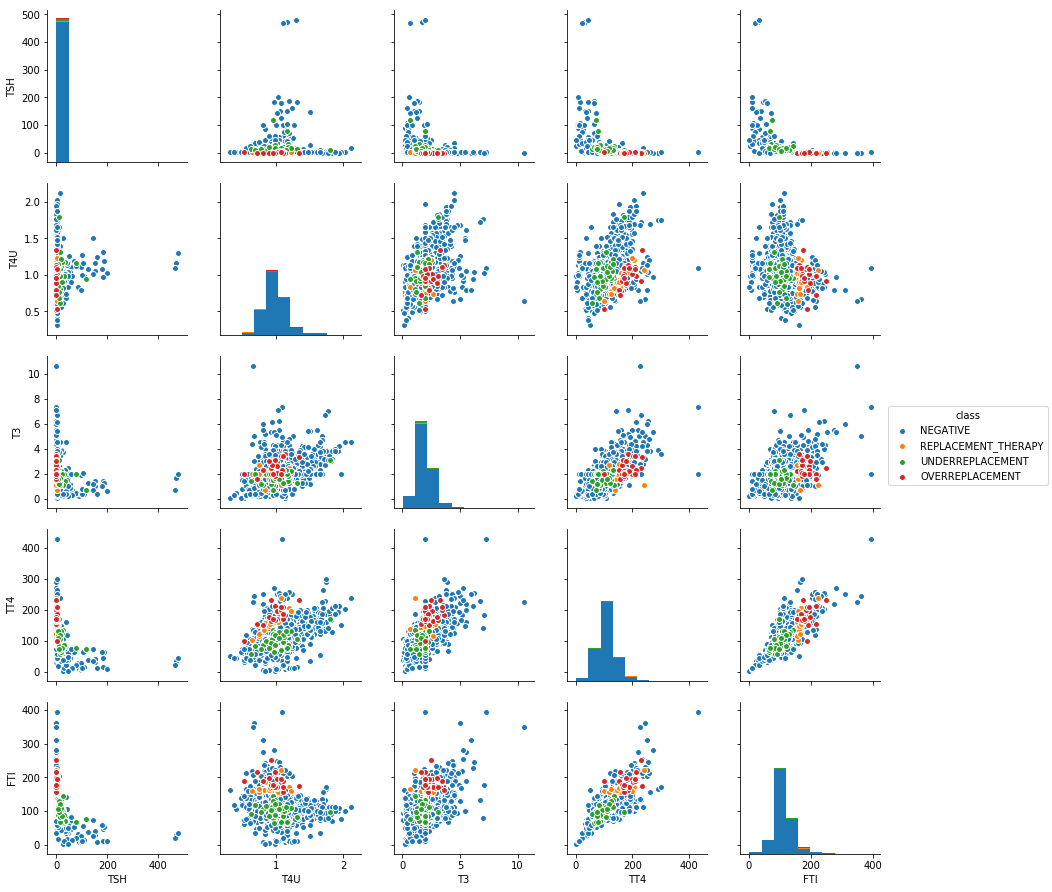

In [1012]:
sample = data.dropna()
#seaborn.pairplot(sample.loc[:,['TSH', 'T4U', 'T3', 'TT4', 'unknown1']])
dataFrame = data.loc[:,['TSH', 'T4U', 'T3', 'TT4']]
dataFrame['FTI'] = pd.to_numeric(data['FTI'], errors='coerce')

column1_name = 'CLASS'

dataFrame['class'] = data['CLASS']
dataFrame = dataFrame.dropna()

seaborn.pairplot(dataFrame, dropna=True, hue='class')

Počet pacientov v jednotlivých skupinách. 

In [1013]:
data['CLASS'].value_counts()

NEGATIVE               2713
UNDERREPLACEMENT         35
REPLACEMENT_THERAPY      29
OVERREPLACEMENT          23
Name: CLASS, dtype: int64

In [1014]:
calculate_recall("dasdsadad", 1, "dsadad")

dasdsadad
1
dsadad


## Atribúty FTI, TT4, T3, T4U

Väčšina pacientov, ktorí majú hodnoty atribútov **FTI, TT4, T3, T4U** také, ako sú špecifikované, tak sú zdravý.

In [ ]:
df = data[(data['FTI'] < 71) | (data['TT4'] < 72) | (data['T3'] > 3.6) | (data['T4U'] > 1.34)]
df['CLASS'].value_counts()

### FTI

In [ ]:
df = data[(data['FTI'] < 71)]
df['CLASS'].value_counts()

### TT4

In [ ]:
df = data[(data['TT4'] < 72)]
df['CLASS'].value_counts()

### T3

In [ ]:
df = data[(data['T3'] > 3.6)]
df['CLASS'].value_counts()

### T4U

In [ ]:
df2 = data[(data['T4U'] > 1.36)]
df2['CLASS'].value_counts()

## Kombinácie atribútov TSH, T3, FTI, T4U, TT4

In [ ]:
df = data[(data['TSH'] < 0.2) & (data['T4U'] < 0.8)]
df['CLASS'].value_counts()

In [ ]:
df = data[(data['TSH'] > 80) | ((data['TSH'] < 1) & (data['T3'] > 3.6)) | ((data['TSH'] > 40) & (data['TSH'] < 75))]
df['CLASS'].value_counts()

In [ ]:
df = data[(data['TSH'] < 37) & (data['T3'] > 3.4)]
df['CLASS'].value_counts()

V nasledujúcej vzorke sme zaznamenali, že nasledovné hodnoty atribútov zaznamenali skoro všetkých pacientov, ktorí majú hodnotu **UNDERREPLACEMENT**.

In [1067]:
df = data[(data['TSH'] > 5) & ((data['FTI'] > 63) & (data['FTI'] < 145))]
test = df['CLASS']
df['CLASS'].value_counts()

# podmienka nasla 237
# z toho je 33 UNDERREPLACEMENT
# v celom data sete je 35
# recall = 33/35
# precision = 33/237

NEGATIVE            204
UNDERREPLACEMENT     33
Name: CLASS, dtype: int64

In [1066]:
data[((data['CLASS'] == 'UNDERREPLACEMENT'))].count().head(1)

AGE    35
dtype: int64

In [1061]:
chcel_som = data[((data['TSH'] > 5) & ((data['FTI'] > 63) & (data['FTI'] < 145))) & ((data['CLASS'] == 'UNDERREPLACEMENT'))]
chcel_som

,AGE,SEX,ON_THYROXINE,QUERY_ON_THYROXINE,ON_ANTITHYROID_MEDICATION,SICK,PREGNANT,THYROID_SURGERY,I131_TREATMENT,QUERY_HYPOTHYROID,...,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,DATE_OF_BIRTH,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,,,,,,,,,,,,,
28,64.0,FEMALE,True,False,False,False,False,False,False,False,...,0.0,0.0,40,1953-06-10,OTHER_SERVICE,PHILIPPINES,MARRIED_CIV_SPOUSE,PRIVATE,ASIAN_PAC_ISLANDER,UNDERREPLACEMENT
292,18.0,MALE,True,False,False,False,False,False,True,True,...,0.0,0.0,42,1999-09-23,PROTECTIVE_SERV,UNITED_STATES,MARRIED_CIV_SPOUSE,STATE_GOV,WHITE,UNDERREPLACEMENT
365,60.0,MALE,True,False,False,False,False,False,False,False,...,0.0,0.0,50,1958-01-25,PROF_SPECIALTY,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,UNDERREPLACEMENT
374,62.0,MALE,True,False,False,False,False,False,False,True,...,2829.0,0.0,40,NaT,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,UNDERREPLACEMENT
458,29.0,FEMALE,True,False,False,False,False,False,False,False,...,NaN,0.0,40,1988-10-21,OTHER_SERVICE,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK,UNDERREPLACEMENT
463,69.0,FEMALE,True,True,False,False,False,False,False,False,...,0.0,0.0,32,1948-06-03,SALES,DOMINICAN_REPUBLIC,NEVER_MARRIED,PRIVATE,BLACK,UNDERREPLACEMENT
503,50.0,MALE,True,False,False,False,False,False,False,False,...,NaN,0.0,12,1967-04-13,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,UNDERREPLACEMENT
842,80.0,FEMALE,True,False,False,False,False,False,False,False,...,0.0,0.0,45,1937-12-12,PROF_SPECIALTY,UNITED_STATES,MARRIED_CIV_SPOUSE,STATE_GOV,WHITE,UNDERREPLACEMENT
907,38.0,FEMALE,True,False,False,False,False,False,False,False,...,NaN,0.0,40,1979-11-18,EXEC_MANAGERIAL,UNITED_STATES,DIVORCED,PRIVATE,ASIAN_PAC_ISLANDER,UNDERREPLACEMENT


V nasledujúcej vzorke sme zaznamenali, že nasledovné hodnoty atribútov zaznamenali väčšinu pacientov, ktorí majú hodnotu **OVERREPLACEMENT** alebo **REPLACEMENT_THERAPY**.

In [1054]:
df = data[(data['TSH'] < 1) & ((data['FTI'] > 155) & (data['FTI'] < 225))]
df['CLASS'].value_counts()

'''
chcel_som = data[(data['TSH'] < 1) & ((data['FTI'] > 155) & (data['FTI'] < 225)) & ((data['CLASS'] == 'REPLACEMENT_THERAPY') | (data['CLASS'] == 'OVERREPLACEMENT'))]
#df['CLASS'].value_counts()
df['AGE'].count()
'''

NEGATIVE               99
REPLACEMENT_THERAPY    26
OVERREPLACEMENT        22
Name: CLASS, dtype: int64

In [1031]:
def calculator(x):
    data[]
    calculate_recall(x)

## Atribúty ON_ANTITHYROID_MEDICATION, I131_TREATMENT, LITHIUM, THYROID_SURGERY

Z nasledujúcej vzorky môžme povedať, že väčšina pacientov, ktorí boli na nejakej forme liečenia, alebo na operácii štítnej žlazy, tak sú zdravý.

In [ ]:
df = data[
    (data['ON_ANTITHYROID_MEDICATION'] == True) | # nejaká liečba štítnej žlazy
    (data['I131_TREATMENT'] == True) |    # liečba rádiojódom
    (data['LITHIUM'] == True) |    # užíval lithium
    (data['THYROID_SURGERY'] == True)   # operácia štítnej žlazy
]
df['CLASS'].value_counts()

Európania v našom datasete sú zdravý. (nič divné, kedže európania tvoria len veľmi malú časť datasetu).

In [ ]:
data['STATE'].value_counts()
df = data[(data['STATE'] == 'GERMANY') | 
          (data['STATE'] == 'POLAND') | 
          (data['STATE'] == 'ENGLAND') |
          (data['STATE'] == 'ENGLAND') |
          (data['STATE'] == 'ITALY') |
          (data['STATE'] == 'GREECE') | 
          (data['STATE'] == 'SCOTLAND') 
         ]
df['CLASS'].value_counts()

In [ ]:
dataFrame = data.loc[:,data.select_dtypes('bool').columns]

column1_name = 'CLASS'

dataFrame['class'] = data['CLASS']
dataFrame = dataFrame.dropna()


seaborn.pairplot(dataFrame[dataFrame['class'] != 'negative'], dropna=True, hue='class')

In [ ]:
dataFrame = data.loc[:,['TSH', 'T4U', 'T3', 'TT4']]
dataFrame['FTI'] = pd.to_numeric(data['FTI'], errors='coerce')

column1_name = 'CLASS'

dataFrame['lithium'] = data['LITHIUM']
dataFrame = dataFrame.dropna()

seaborn.pairplot(dataFrame, dropna=True, hue='lithium')